# Interactive monitoring of a parallel MPI simulation with the IPython Notebook

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.parallel import Client, error

cluster = Client(profile="mpi")
view = cluster[:]
view.block = True

In [2]:
cluster.ids

[0, 1, 2, 3]

Now, we load the MPI libraries into the engine namespaces, and do a simple printing of their MPI rank information to verify that all nodes are operational and they match our cluster's real capacity.  

Here, we are making use of IPython's special `%%px` cell magic, which marks the entire cell for parallel execution.  This means that the code below will not run in this notebook's kernel, but instead will be sent to *all* engines for execution there.  In this way, IPython makes it very natural to control your entire cluster from within the notebook environment:

In [3]:
%%px
# MPI initialization, library imports and sanity checks on all engines
from mpi4py import MPI
import numpy as np
import time

mpi = MPI.COMM_WORLD
bcast = mpi.bcast
barrier = mpi.barrier
rank = mpi.rank
print("MPI rank: %i/%i" % (mpi.rank,mpi.size))

[stdout:0] MPI rank: 3/4
[stdout:1] MPI rank: 2/4
[stdout:2] MPI rank: 0/4
[stdout:3] MPI rank: 1/4


We write a utility that reorders a list according to the mpi ranks of the engines, since all gather operations will return data in engine id order, not in MPI rank order.  We'll need this later on when we want to reassemble in IPython data structures coming from all the engines: IPython will collect the data ordered by engine ID, but our code creates data structures based on MPI rank, so we need to map from one indexing scheme to the other.  This simple function does the job:

In [4]:
ranks = view['rank']
rank_indices = np.argsort(ranks)

def mpi_order(seq):
    """Return elements of a sequence ordered by MPI rank.

    The input sequence is assumed to be ordered by engine ID."""
    return [seq[x] for x in rank_indices]

## MPI simulation example

This is our 'simulation', a toy example that computes $\sin(f(x^2+y^2))$ for a slowly increasing frequency $f$ over a gradually refined mesh.  In a real-world example, there typically is a 'simulate' method that, afer setting up initial parameters, runs the entire computation.  But having this simple example will be sufficient to see something that changes visually as the computation evolves and that is quick enough for us to test.

And while simple, this example has a realistic decomposition of the spatial domain in one array per MPI node that requires care in reordering the data for visualization, as would be needed in a real-world application (unless your code accumulates data in the rank 0 node that you can grab directly).

In [5]:
%%px

stop = False
nsteps = 100
delay = 0.1

xmin, xmax = 0, np.pi
ymin, ymax = 0, 2*np.pi
dy = (ymax-ymin)/mpi.size

def simulation():
    """Toy simulation code, computes sin(f*(x**2+y**2)) for a slowly increasing f
    over an increasingly fine mesh.

    The purpose of this code is simply to illustrate the basic features of a typical
    MPI code: spatial domain decomposition, a solution which is evolving in some 
    sense, and local per-node computation.  In this case the nodes don't really
    communicate at all.
    """
    # By making these few variables global, we allow the IPython client to access them
    # remotely for interactive introspection
    global j, Z, nx, nyt
    freqs = np.linspace(0.6, 1, nsteps)
    for j in range(nsteps):
        nx, ny = 2+j/4, 2+j/2/mpi.size
        nyt = mpi.size*ny
        Xax = np.linspace(xmin, xmax, nx)
        Yax = np.linspace(ymin+rank*dy, ymin+(rank+1)*dy, ny, endpoint=rank==mpi.size)
        X, Y = np.meshgrid(Xax, Yax)
        f = freqs[j]
        Z = np.cos(f*(X**2 + Y**2))
        # We add a small delay to simulate that a real-world computation
        # would take much longer, and we ensure all nodes are synchronized
        time.sleep(delay)
        # The stop flag can be set remotely via IPython, allowing the simulation to be
        # cleanly stopped from the outside
        if stop:
            break

## IPython tools to interactively monitor and plot the MPI results

We now define a local (to this notebook) plotting function that fetches data from the engines' global namespace.  Once it has retrieved the current state of the relevant variables, it produces and returns a figure:

In [6]:
from IPython.display import clear_output

def plot_current_results(in_place=True):
    """Makes a blocking call to retrieve remote data and displays the solution mesh
    as a contour plot.
    
    Parameters
    ----------
    in_place : bool
        By default it calls clear_output so that new plots replace old ones.  Set
        to False to allow keeping of all previous outputs.
    """
    
    # We make a blocking call to load the remote data from the simulation into simple named 
    # variables we can read from the engine namespaces
    #view.apply_sync(load_simulation_globals)
    # And now we can use the view to read these variables from all the engines.  Then we
    # concatenate all of them into single arrays for local plotting
    try:
        Z = np.concatenate(mpi_order(view['Z']))
    except ValueError:
        print("dimension mismatch in Z, not plotting")
        ax = plt.gca()
        return ax.figure
        
    nx, nyt, j, nsteps = view.pull(['nx', 'nyt', 'j', 'nsteps'], targets=0)
    fig, ax = plt.subplots()
    ax.contourf(Z)
    ax.set_title('Mesh: %i x %i, step %i/%i' % (nx, nyt, j+1, nsteps))
    plt.axis('off')
    # We clear the notebook output before plotting this if in-place plot updating is requested
    if in_place:
        clear_output(wait=True)
    display(fig)
    return fig

It will also be useful to be able to check whether the simulation is still alive or not.  Below we will wrap the main simulation function into a thread to allow IPython to pull data from the engines, and we will call this object `simulation_thread`.  So to check whether the code is still running, all we have to do is call the `is_alive` method on all of our engines and see whether any of them returns True:

In [7]:
def simulation_alive():
    """Return True if the simulation thread is still running on any engine.
    """
    return any(view.apply_sync(lambda : simulation_thread.is_alive()))

Finally, this is a convenience wrapper around the plotting code so that we can interrupt monitoring at any point, and that will provide basic timing information:

In [8]:
def monitor_simulation(refresh=5.0, plots_in_place=True):
    """Monitor the simulation progress and call plotting routine.

    Supress KeyboardInterrupt exception if interrupted, ensure that the last 
    figure is always displayed and provide basic timing and simulation status.

    Parameters
    ----------
    refresh : float
      Refresh interval between calls to retrieve and plot data.  The default
      is 5s, adjust depending on the desired refresh rate, but be aware that 
      very short intervals will start having a significant impact.

    plots_in_place : bool
       If true, every new figure replaces the last one, producing a (slow)
       animation effect in the notebook.  If false, all frames are plotted
       in sequence and appended in the output area.
    """
    import datetime as dt, time
    
    if not simulation_alive():
        plot_current_results(in_place=plots_in_place)
        plt.close('all')
        print('Simulation has already finished, no monitoring to do.')
        return
    
    t0 = dt.datetime.now()
    fig = None
    try:
        while simulation_alive():
            fig = plot_current_results(in_place=plots_in_place)
            plt.close('all') # prevent re-plot of old figures
            time.sleep(refresh) # so we don't hammer the server too fast
    except (KeyboardInterrupt, error.TimeoutError):
        msg = 'Monitoring interrupted, simulation is ongoing!'
    else:
        msg = 'Simulation completed!'
    tmon = dt.datetime.now() - t0
    if plots_in_place and fig is not None:
        clear_output(wait=True)
        plt.close('all')
        display(fig)
    print(msg)
    print('Monitored for: %s.' % tmon)

## Making a simulation object that can be monitored interactively

In [9]:
%%px
from threading import Thread
stop = False
nsteps = 100
delay=0.5
# Create a thread wrapper for the simulation. The target must be an argument-less
# function so we wrap the call to 'simulation' in a simple lambda:
simulation_thread = Thread(target = lambda : simulation())
# Now we actually start the simulation
simulation_thread.start()

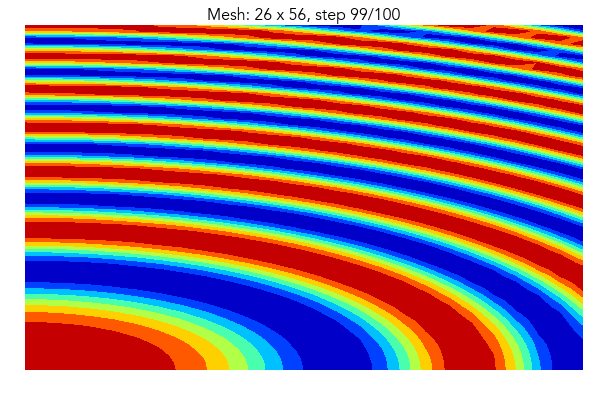

Simulation completed!
Monitored for: 0:00:50.653178.


In [10]:
monitor_simulation(refresh=1);

If you execute the following cell before the MPI code is finished running, it will stop the simulation at that point, which you can verify by calling the monitoring again:

In [11]:
view['stop'] = True

In [12]:
%%px --target 0
from IPython.parallel import bind_kernel; bind_kernel()
%connect_info

{
  "stdin_port": 65310, 
  "ip": "127.0.0.1", 
  "control_port": 58188, 
  "hb_port": 58187, 
  "key": "e4f5cda8-faa8-48d3-a62c-dbde67db9827", 
  "shell_port": 65083, 
  "transport": "tcp", 
  "iopub_port": 54934
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing kernel-64604.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [13]:
%%px --target 0
%qtconsole